# Tales of London's Busiest & Quietest Stations

Author: Eu Meng Chong  
Course: Final Capstone Project under Applied Data Science Capstone by IBM  
Date Published: 08th June 2020

## Table of Contents

1. [Introduction](#Introduction)
2. [Data](#Data)
3. [Methodology](#Methodology)
4. [Results](#Results)
5. [Discussions](#Discussions)
6. [Conclusion](#Conclusion)


## 1. Introduction <a name= "Introduction"> </a>

With the world oldest metro system which is known as the London Underground, alongside with the Overground and privately owwned commuter trains services, London has one of the most extensive rail network in the world, consisting a total of 330 stations. Moreover, as mentioned in this [webpage](https://en.wikipedia.org/wiki/Rail_transport_in_Great_Britain), London and Southeaast England (counted together as their railway network are more integrated) has a annual passenger count of 1.216 billion between 2018 - 2019 and the trend is steadily increasing.

In this project, we would like to first look into the neighbourhoods surrounding these railway stations in London and classify them whether they are having high volume of trains stopping by or otherwise. Fortunately, the Department of Transport (DfT) has categorised all the stations in the UK (London included) based on that metric from A being the highest to F2 being the lowest. Moreover, as not all the neighbourhoods surrounding each stations are made equal (i.e. some neighbourhoods are solely residental, others having more commercial or corporate area surrounding it), we will use the assumption which is the purpose of usage of each stations is solely determined by venues closest to a it. For example, if there are no residental areas in a neighborhood, then the passengers at the particular station could be using it to travel back home for work. This instance is one example of daily migrations of people in a city as populous as London.

What we would like to acheive from this project is to construct a calssification model based on these data on each neighbourhoods surrounding the stations to determine the their respective volume of trains stopping by on their respective stations. In fact, this model has the potential to determine the factors which affect the ridership count on each train stations in London and could be used to pinpoint a profitable railway network extensions in London.

## 2. Data <a name = "Data"> </a>

We will use the following sources to retrieve the abovementioned data:
1. https://en.wikipedia.org/wiki/List_of_London_railway_stations: This webpage provides the list of all the railway stations in London with their respective coordinates, operators, DfT Categories and the Boroughs in London. Here we shall use the Python package of `BeautifulSoup` to scrape the table from the webpage.


In [1]:
# Installing packages
! pip install bs4
print("Package Installed!")

  Stored in directory: /home/dsxuser/.cache/pip/wheels/a0/b0/b2/4f80b9456b87abedbc0bf2d52235414c3467d8889be38dd472
Successfully built bs4
Package Installed!


In [2]:
# Importing libraries
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import requests
print("Packages Imported!")

Packages Imported!


In [3]:
# Scrapping Webpage
webpage = requests.get('https://en.wikipedia.org/wiki/List_of_London_railway_stations').text
soup = BeautifulSoup(webpage,'lxml')
print("Webpage Scrapped!")

Webpage Scrapped!


Next, having the desired table located, we shall start extract the said table with the following command and place it under the `pandas` Dataframe

In [4]:
My_table = soup.find('table',{'class':'wikitable sortable'})

In [5]:
indices = [0,1,2,6,7]

stations_df = pd.DataFrame(columns=['Station','Borough','Managed By','DfT Category','Coordinates'])

for tr in My_table.find_all('tr')[1:]:
    cells = tr.find_all('td')
    #ignore cells that don't have coordinates
    if cells[0].text.strip() != '':
        stations_df = stations_df.append({
            'Station': cells[0].text.strip(),
            'Borough': cells[1].text.strip(),
            'Managed By': cells[2].text.strip(),
            'DfT Category': cells[6].text.strip(),
            'Coordinates': cells[7].find('span', {'class': 'geo'}).text.strip().replace('; ',',')
        }, ignore_index=True)

stations_df.head()
stations_df.to_csv('London_stations.csv')
print("File saved.")

File saved.


Finally, let's look at the table we have made...

In [6]:
# Now, let's read the file
stations_df = pd.read_csv('London_stations.csv', index_col=0)
stations_df.head()

,Station,Borough,Managed By,DfT Category,Coordinates
0,Abbey Wood,Greenwich,TfL Rail[1],C,"51.4915,0.1229"
1,Acton Central,Ealing,London Overground,D,"51.5088,-0.2634"
2,Acton Main Line[2],Ealing,TfL Rail,E,"51.5169,-0.2669"
3,Albany Park,Bexley,Southeastern,D,"51.4358,0.1266"
4,Alexandra Palace[3],Haringey,Great Northern,D,"51.5983,-0.1197"


In [7]:
# Removing the ones which are not classified in DfT Category
stations_df = stations_df[stations_df['DfT Category']!= 'unlisted']
stations_df.head()

,Station,Borough,Managed By,DfT Category,Coordinates
0,Abbey Wood,Greenwich,TfL Rail[1],C,"51.4915,0.1229"
1,Acton Central,Ealing,London Overground,D,"51.5088,-0.2634"
2,Acton Main Line[2],Ealing,TfL Rail,E,"51.5169,-0.2669"
3,Albany Park,Bexley,Southeastern,D,"51.4358,0.1266"
4,Alexandra Palace[3],Haringey,Great Northern,D,"51.5983,-0.1197"


2. Next, we shall use the Foursquare API to explore venue types surrounding each station. As a matter in fact, Foursquare also label categories on each venue categories with a more refined sub-categories. We may find such list of categories with its corresponding Category ID [here](https://developer.foursquare.com/docs/build-with-foursquare/categories/). Here are the example of categories we are interested to look at:-
    - Arts & Entertainment; 4d4b7104d754a06370d81259
    - College & University; 4d4b7105d754a06372d81259
    - Events; 4d4b7105d754a06373d81259
    - Food; 4d4b7105d754a06374d81259
    - Outdoors & Recreation; 4d4b7105d754a06377d81259
    - Professional & Other Places; 4d4b7105d754a06375d81259
    - Residence; 4e67e38e036454776db1fb3a
    - Shop & service; 4d4b7105d754a06378d81259
    - Travel & Transport; 4d4b7105d754a06379d81259
    
Here, for each stations, we shall only consider all the venues within 1000m radius surrounding it to be its neighbourhood as 1000m is a approximately a the distance travelled in a 15-minute walk, which makes such range a reasonable enough to identify the main usage of each stations.

We shall start by loading our client ID and secret into this notebook.

In [8]:
# @hidden cell
CLIENT_ID = 'IC5UWCUG3GCZR1O2ZPH1DQ232SSELZK2SMUCSQCBBNZ2152A'
CLIENT_SECRET = 'SLGKZEC1QULW05SHVPU1B5UNQCVPDY1LNSYDZFKBVEQMYFZS'
VERSION = '20200601'
print("Credentials Loaded!")

Credentials Loaded!


Next, we need to retrieve a list of venue categories which are labelled in Foursquare, which we then identify the total number of distinct categories prent in the said data.

In [9]:
categories_url = 'https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
# make the GET request
Cat = requests.get(categories_url).json()

In [11]:
len(Cat['response']['categories'])

10

We have identified that there are a total of 10 venue categories present in Foursquare. Now, let's identify what are those venue categories present in such listing.

In [132]:
categories_list = []
# Let's print only the top-level categories and their IDs and also add them to categories_list

def print_categories(categories, level=0, max_level=0):    
    if level>max_level: return
    out = ''
    out += '-'*level
    for category in categories:
        print(out + category['name'] + ' (' + category['id'] + ')')
        print_categories(category['categories'], level+1, max_level)
        categories_list.append((category['name'], category['id']))
        
print_categories(Cat['response']['categories'], 0, 0)

Arts & Entertainment (4d4b7104d754a06370d81259)
College & University (4d4b7105d754a06372d81259)
Event (4d4b7105d754a06373d81259)
Food (4d4b7105d754a06374d81259)
Nightlife Spot (4d4b7105d754a06376d81259)
Outdoors & Recreation (4d4b7105d754a06377d81259)
Professional & Other Places (4d4b7105d754a06375d81259)
Residence (4e67e38e036454776db1fb3a)
Shop & Service (4d4b7105d754a06378d81259)
Travel & Transport (4d4b7105d754a06379d81259)


## 3. Methodology <a name="Methodology"></a>

In [14]:
def get_venues_count(ll, radius, categoryId):
    explore_url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={}&radius={}&categoryId={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION,
                ll,
                radius,
                categoryId)

    # make the GET request
    jsonBlob = requests.get(explore_url).json()
    if 'response' not in jsonBlob or 'totalResults' not in jsonBlob['response']:
        return np.nan
    else:
        return requests.get(explore_url).json()['response']['totalResults']

In [15]:
#Create new dataframe to store venues data
stations_venues_df = stations_df.copy()
for c in categories_list:
    stations_venues_df[c[0]] = 0

In [40]:
#Request number of venues, store result as CSV
for i, row in stations_venues_df.iterrows():
    print(i)
    if i >= 330: # Note: We set arbitrary values to ensure that the we can pick up where we last left after the execution of the code is being crashed.
        for c in categories_list:        
            stations_venues_df.loc[i, c[0]] = get_venues_count(stations_venues_df.Coordinates.iloc[i], radius=1000, categoryId=c[1])
    stations_venues_df.to_csv('stations_venues.csv')

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

After a long wait, let's give a quick check to see whether all the results from Foursquare are being loaded.

In [41]:
stations_venues_df = stations_venues_df.reset_index(drop = True)
stations_venues_df.tail()

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
344,Woodmansterne,Croydon,Southern,E,"51.3192,-0.1539",3.0,0.0,0.0,6.0,3.0,2.0,9.0,1.0,1.0,3.0
345,Wood Street[48],Waltham Forest,London Overground,D,"51.5864,-0.0021",4.0,3.0,0.0,18.0,11.0,5.0,19.0,2.0,19.0,4.0
346,Woolwich Arsenal,Greenwich,Southeastern,C,"51.4898,0.0694",4.0,11.0,0.0,22.0,7.0,10.0,28.0,4.0,42.0,15.0
347,Woolwich Dockyard[65],Greenwich,Southeastern,E,"51.4913,0.0536",3.0,4.0,0.0,16.0,4.0,5.0,17.0,3.0,30.0,9.0
348,Worcester Park[66],Sutton,South Western Railway,C,"51.3804,-0.2412",2.0,0.0,0.0,9.0,5.0,2.0,6.0,3.0,15.0,7.0


### Exploratory analysis & basic cleanup <a name="Exp"></a>

Now, with the dataframe prepared, now let's us clean the data with the following steps:-
- Removing NaN Data as these data are not useful to train or test our model.

In [45]:
df = stations_venues_df.dropna(axis = 0).reset_index(drop=True)
df.shape

(182, 15)

It appears that there are a significant number of stations which have NaN Data in them. Next, we need to take a quick look on the list of distinct Operators, DfT categories and Boroughs at each stations.

In [47]:
df['Borough'].unique()

array(['Greenwich', 'Ealing', 'Bexley', 'Haringey', 'Bromley',
       'Wandsworth', 'Reigate and Bansteadout-boundary',
       'Barking and Dagenham', 'Richmond upon Thames', 'Lewisham',
       'Sutton', 'Kingston upon Thames', 'Tower Hamlets',
       'City of London', 'Waltham Forest', 'Hounslow',
       'Brentwoodout-boundary', 'Enfield', 'Lambeth', 'Brent',
       'Broxbourneout-boundary', 'Watfordout-boundary', 'Islington',
       'Camden', 'Three Riversout-boundary', 'Tandridgeout-boundary',
       'Redbridge', 'Thurrockout-boundary', 'Westminster', 'Hackney',
       'Croydon', 'Barnet', 'Southwark', 'Hertsmereout-boundary',
       'Havering', 'Epsom and Ewellout-boundary', 'Newham',
       'Elmbridgeout-boundary', 'Harrow', 'Merton', 'Hillingdon',
       'Hammersmith and Fulham', 'Kensington and Chelsea'], dtype=object)

In [60]:
df['DfT Category'].unique()

array(['C', 'D', 'E', 'B', 'F', 'A', 'C/Fe'], dtype=object)

In [48]:
df['Managed By'].unique()

array(['TfL Rail[1]', 'London Overground', 'TfL Rail', 'Southeastern',
       'Great Northern', 'Southern', 'c2c', 'South Western Railway',
       'Thameslink', 'London Underground', 'Greater Anglia',
       'Network Rail', 'Great Western Railway', 'Chiltern Railways'],
      dtype=object)

As there are stations listed in the Wikipedia webpage which are **not** in Greater London (i.e. with the string '-boundary' attached in the Borough column), plus the special characters which may cause issues on the classification modelling in the Managed_By column, and finally the DfT_Category labelled 'C/Fe' which is deemed confusing, we shall do the following:-

- Clean both columns of Borough and Managed_By, and
- Identify the station(s) with the DfT Category of 'C/Fe' and fix a appropriate category in the dataframe.

In [50]:
# Removing Stations outside Greater London (with string of '-boundary' in Borough Column).
df = df[~df.Borough.str.contains("-boundary")].reset_index(drop = True)
df.tail()

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
161,Woodmansterne,Croydon,Southern,E,"51.3192,-0.1539",3.0,0.0,0.0,6.0,3.0,2.0,9.0,1.0,1.0,3.0
162,Wood Street[48],Waltham Forest,London Overground,D,"51.5864,-0.0021",4.0,3.0,0.0,18.0,11.0,5.0,19.0,2.0,19.0,4.0
163,Woolwich Arsenal,Greenwich,Southeastern,C,"51.4898,0.0694",4.0,11.0,0.0,22.0,7.0,10.0,28.0,4.0,42.0,15.0
164,Woolwich Dockyard[65],Greenwich,Southeastern,E,"51.4913,0.0536",3.0,4.0,0.0,16.0,4.0,5.0,17.0,3.0,30.0,9.0
165,Worcester Park[66],Sutton,South Western Railway,C,"51.3804,-0.2412",2.0,0.0,0.0,9.0,5.0,2.0,6.0,3.0,15.0,7.0


In [59]:
# Removing special and numerical characters in Managed_by column.
for i in ['[',']','\d+']:
    df['Managed By'] = df['Managed By'].str.replace(i, '')
    df['Station'] = df['Station'].str.replace(i, '')
df.head()

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,Greenwich,TfL Rail,C,"51.4915,0.1229",1.0,1.0,0.0,6.0,5.0,4.0,3.0,2.0,7.0,4.0
1,Acton Central,Ealing,London Overground,D,"51.5088,-0.2634",4.0,4.0,0.0,26.0,12.0,17.0,30.0,3.0,32.0,9.0
2,Acton Main Line,Ealing,TfL Rail,E,"51.5169,-0.2669",3.0,2.0,0.0,22.0,4.0,10.0,22.0,6.0,19.0,13.0
3,Albany Park,Bexley,Southeastern,D,"51.4358,0.1266",1.0,2.0,0.0,5.0,5.0,2.0,6.0,0.0,18.0,2.0
4,Alexandra Palace,Haringey,Great Northern,D,"51.5983,-0.1197",4.0,4.0,0.0,34.0,14.0,17.0,27.0,4.0,46.0,13.0


In [61]:
# Identify the station(s) which has DfT category of 'C/Fe'.
df[df['DfT Category']=='C/Fe']

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Event,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
130,Highbury & Islington,Islington,London Underground,C/Fe,"51.5458,-0.1050",4.0,3.0,0.0,30.0,8.0,16.0,12.0,7.0,13.0,12.0


Upon consulting the footnote provided on the station in Wikipedia, this particular station has 2 distinct DfT categories as Govia Thameslink Railway platforms categorised C and London Overground platforms categorised E. As the Managed_By column is set to be 'London Overground', it is wise for us to use DfT category to be 'E' instead of 'C'.

In [63]:
df['DfT Category'] = df['DfT Category'].replace('C/Fe','E')
df['DfT Category'].unique()

array(['C', 'D', 'E', 'B', 'F', 'A'], dtype=object)

With the DfT Categories fixed into 6 desired categories, we have done with the data cleanup!

Now, we shall start with some Exploratory analysis on the cleaned dataframe. We shall first take a look on the distribution of the Venue Categories of the whole dataframe.

In [66]:
import seaborn as sns
from matplotlib import pyplot as plt

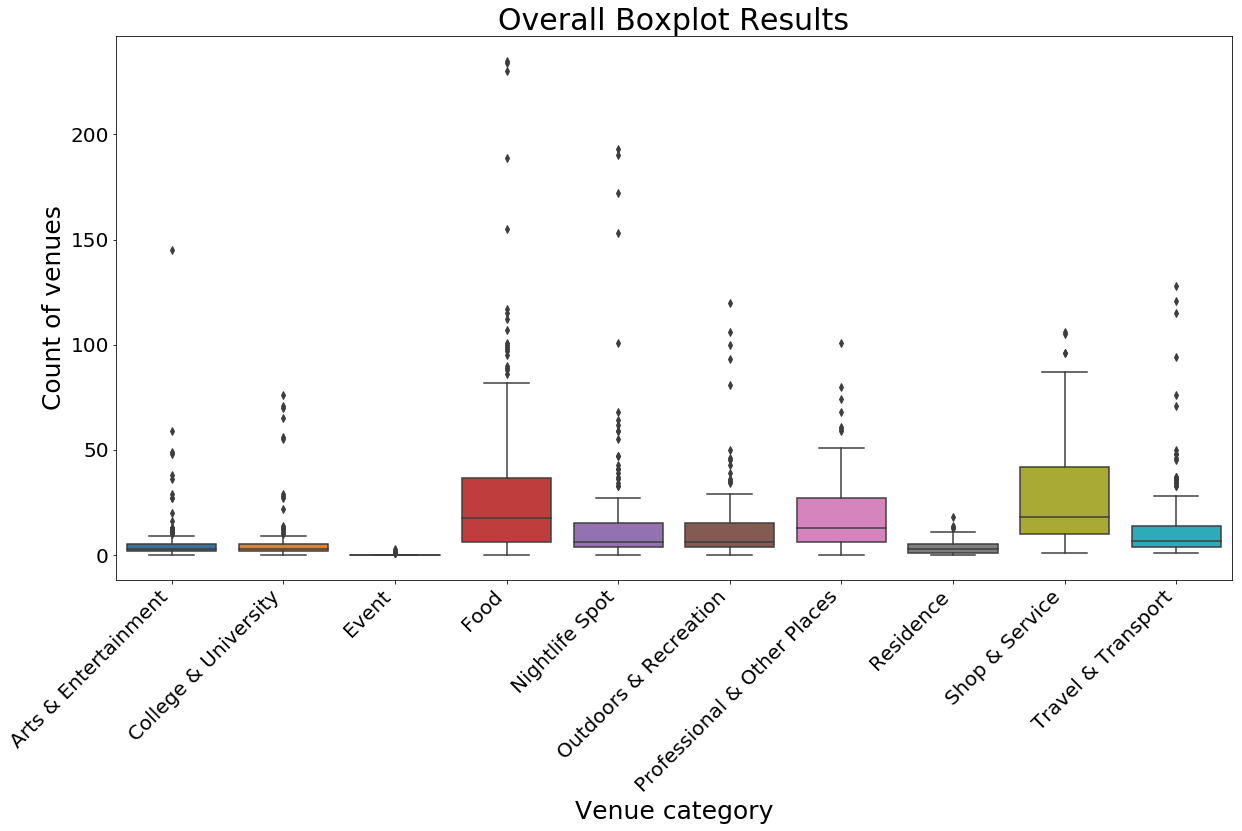

In [91]:
plt.figure(figsize=(20, 10))
plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = df)
ax.set_ylabel('Count of venues', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
ax.set_title('Overall Boxplot Results', fontsize = 30)
plt.xticks(rotation=45, ha='right')


plt.show()

... and of course, boxplots on each DfT Categories.

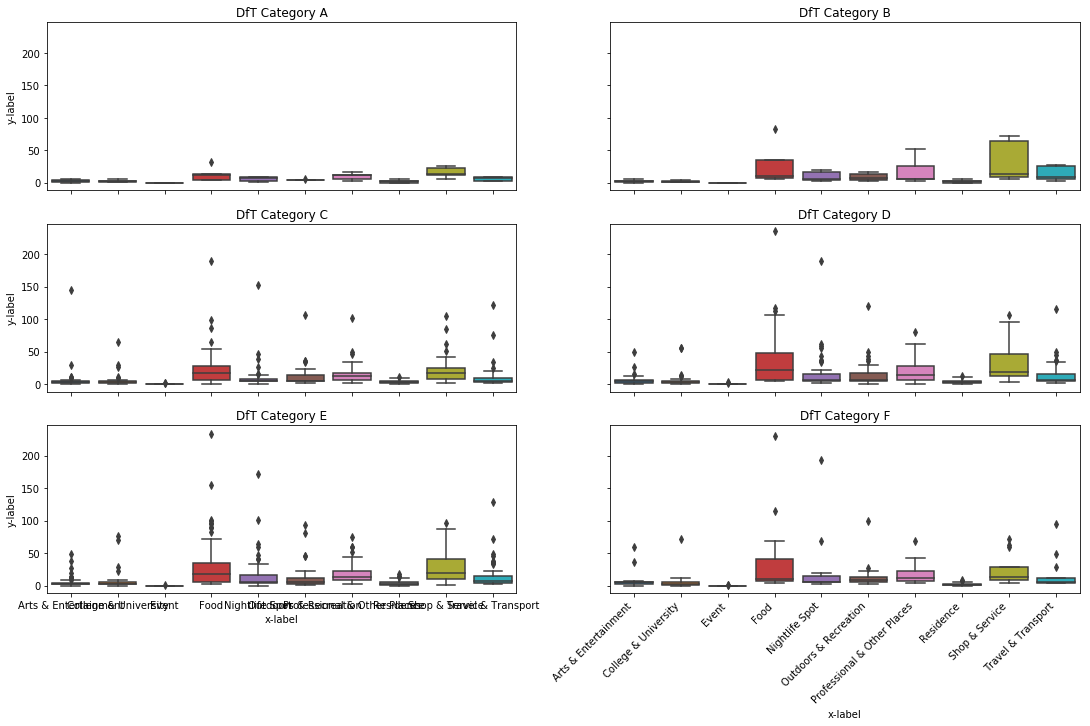

In [119]:

fig, axs = plt.subplots(3,2,sharex=True, sharey=True)
fig.set_size_inches(18.5, 10.5)

sns.boxplot(data=df[df['DfT Category']=='A'], ax=axs[0,0])
axs[0, 0].set_title('DfT Category A')
sns.boxplot(data=df[df['DfT Category']=='B'], ax=axs[0,1])
axs[0, 1].set_title('DfT Category B')
sns.boxplot(data=df[df['DfT Category']=='C'], ax=axs[1,0])
axs[1, 0].set_title('DfT Category C')
sns.boxplot(data=df[df['DfT Category']=='D'], ax=axs[1,1])
axs[1, 1].set_title('DfT Category D')
sns.boxplot(data=df[df['DfT Category']=='E'], ax=axs[2,0])
axs[2, 0].set_title('DfT Category E')
sns.boxplot(data=df[df['DfT Category']=='F'], ax=axs[2,1])
axs[2, 1].set_title('DfT Category F')
plt.xticks(rotation=45, ha='right')

for ax in axs.flat:
    ax.set(xlabel='x-label', ylabel='y-label')

# Hide x labels and tick labels for top plots and y ticks for right plots.
for ax in axs.flat:
    ax.label_outer()

To simply our dataset, we shall remove the only insignificant Venue Category: 'Event' as it has almost to 0 data available under this category.

In [120]:
# Remove the insignificant Venue Categories
df = df.drop('Event',axis=1)
df.head()

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,Greenwich,TfL Rail,C,"51.4915,0.1229",1.0,1.0,6.0,5.0,4.0,3.0,2.0,7.0,4.0
1,Acton Central,Ealing,London Overground,D,"51.5088,-0.2634",4.0,4.0,26.0,12.0,17.0,30.0,3.0,32.0,9.0
2,Acton Main Line,Ealing,TfL Rail,E,"51.5169,-0.2669",3.0,2.0,22.0,4.0,10.0,22.0,6.0,19.0,13.0
3,Albany Park,Bexley,Southeastern,D,"51.4358,0.1266",1.0,2.0,5.0,5.0,2.0,6.0,0.0,18.0,2.0
4,Alexandra Palace,Haringey,Great Northern,D,"51.5983,-0.1197",4.0,4.0,34.0,14.0,17.0,27.0,4.0,46.0,13.0


### Data Preprocessing

Next, we shall normalise our data using `MinMaxScaler` (scale from 0 to 1). This allows us to easily intepret the score as the neighbourhood surrounding each stations have different amount of venues recorded.

In [154]:
from sklearn.preprocessing import MinMaxScaler

X = df.values[:,5:]
X = MinMaxScaler().fit_transform(X)

/opt/conda/envs/Python36/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [156]:
df.iloc[:,5:] = X
df

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,Greenwich,TfL Rail,C&D,"51.4915,0.1229",0.006897,0.013158,0.025532,0.025907,0.033333,0.029703,0.111111,0.057143,0.023622
1,Acton Central,Ealing,London Overground,C&D,"51.5088,-0.2634",0.027586,0.052632,0.110638,0.062176,0.141667,0.297030,0.166667,0.295238,0.062992
2,Acton Main Line,Ealing,TfL Rail,E&F,"51.5169,-0.2669",0.020690,0.026316,0.093617,0.020725,0.083333,0.217822,0.333333,0.171429,0.094488
3,Albany Park,Bexley,Southeastern,C&D,"51.4358,0.1266",0.006897,0.026316,0.021277,0.025907,0.016667,0.059406,0.000000,0.161905,0.007874
4,Alexandra Palace,Haringey,Great Northern,C&D,"51.5983,-0.1197",0.027586,0.052632,0.144681,0.072539,0.141667,0.267327,0.222222,0.428571,0.094488
5,Anerley,Bromley,London Overground,E&F,"51.4125,-0.0651",0.082759,0.026316,0.157447,0.088083,0.100000,0.227723,0.166667,0.390476,0.070866
6,Balham,Wandsworth,Southern,C&D,"51.4426,-0.1520",0.000000,0.013158,0.017021,0.000000,0.033333,0.029703,0.166667,0.057143,0.015748
7,Barking,Barking and Dagenham,cc,A&B,"51.5393,0.0817",0.000000,0.013158,0.021277,0.025907,0.025000,0.049505,0.000000,0.038095,0.015748
8,Barnehurst,Bexley,Southeastern,C&D,"51.4648,0.1595",0.048276,0.065789,0.076596,0.041451,0.100000,0.148515,0.277778,0.209524,0.078740
9,Barnes,Richmond upon Thames,South Western Railway,C&D,"51.4671,-0.2420",0.062069,0.039474,0.072340,0.041451,0.133333,0.168317,0.111111,0.152381,0.047244


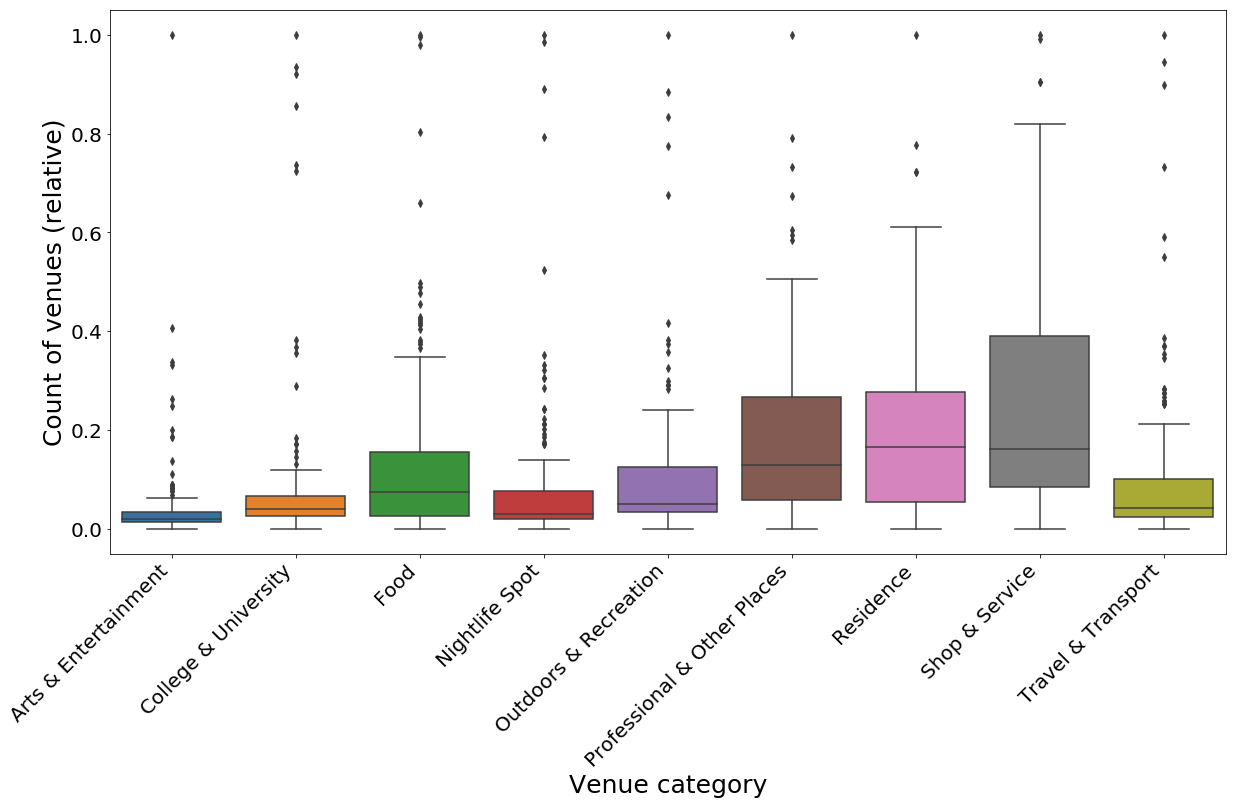

In [158]:
# Time to visualise our scaled data...
plt.figure(figsize=(20, 10))
#plt.xticks(rotation='vertical')
sns.boxplot

ax = sns.boxplot(data = df)
ax.set_ylabel('Count of venues (relative)', fontsize=25)
ax.set_xlabel('Venue category', fontsize=25)
ax.tick_params(labelsize=20)
plt.xticks(rotation=45, ha='right')

plt.show()

Next, as the distribution of the venue categories are similar for DfT Category of A and B, C and D, and lastly E and F, we shall simmplify the dataset by grouping these DfT categories accordingly.

In [159]:
df['DfT Category'] = df['DfT Category'].replace(['A','B','C','D','E','F'],['A&B','A&B','C&D','C&D','E&F','E&F'])
df.head()

,Station,Borough,Managed By,DfT Category,Coordinates,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,Abbey Wood,Greenwich,TfL Rail,C&D,"51.4915,0.1229",0.006897,0.013158,0.025532,0.025907,0.033333,0.029703,0.111111,0.057143,0.023622
1,Acton Central,Ealing,London Overground,C&D,"51.5088,-0.2634",0.027586,0.052632,0.110638,0.062176,0.141667,0.297030,0.166667,0.295238,0.062992
2,Acton Main Line,Ealing,TfL Rail,E&F,"51.5169,-0.2669",0.020690,0.026316,0.093617,0.020725,0.083333,0.217822,0.333333,0.171429,0.094488
3,Albany Park,Bexley,Southeastern,C&D,"51.4358,0.1266",0.006897,0.026316,0.021277,0.025907,0.016667,0.059406,0.000000,0.161905,0.007874
4,Alexandra Palace,Haringey,Great Northern,C&D,"51.5983,-0.1197",0.027586,0.052632,0.144681,0.072539,0.141667,0.267327,0.222222,0.428571,0.094488


Finally, with the attributes which are preprocessed for our needs, let's prepare the final dataset for the next stage: Modelling. 

In [168]:
df_new = df.iloc[:,3:]
df_new.head()

,DfT Category,Coordinates,Arts & Entertainment,College & University,Food,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Residence,Shop & Service,Travel & Transport
0,C&D,"51.4915,0.1229",0.006897,0.013158,0.025532,0.025907,0.033333,0.029703,0.111111,0.057143,0.023622
1,C&D,"51.5088,-0.2634",0.027586,0.052632,0.110638,0.062176,0.141667,0.297030,0.166667,0.295238,0.062992
2,E&F,"51.5169,-0.2669",0.020690,0.026316,0.093617,0.020725,0.083333,0.217822,0.333333,0.171429,0.094488
3,C&D,"51.4358,0.1266",0.006897,0.026316,0.021277,0.025907,0.016667,0.059406,0.000000,0.161905,0.007874
4,C&D,"51.5983,-0.1197",0.027586,0.052632,0.144681,0.072539,0.141667,0.267327,0.222222,0.428571,0.094488


### Modelling: Decision Tree

We shall use decision tree to classify the data based on our modified DfT Categories.

In [232]:
# Importing the necessary packages...
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.metrics import jaccard_similarity_score
from sklearn.metrics import f1_score

In [169]:
# Preparing the modelling dataset, X and its corresponding target dataset, y.
X = df_new.drop(['DfT Category','Coordinates'],axis=1)
y = df_new['DfT Category']

In [199]:
# splitting test set and training set.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (132, 9) (132,)
Test set: (34, 9) (34,)


Now, let's set up the Decision Tree Model using the entropy as criterion. We determine the best maximum depth based on the test-sample accuracy.

In [201]:
# Find the best depth for Decisiopn Tree Modelling...
L = 20
mean_acc2 = np.zeros((L-1))
std_acc2 = np.zeros((L-1))
ConfustionMx = [];
for n in range(1,L):
    
    #Train Model and Predict  
    dTree = DecisionTreeClassifier(criterion="entropy", max_depth = n)
    dTree.fit(X_train, y_train)
    yhat = dTree.predict(X_test)
    mean_acc2[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc2[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc2

array([0.38235294, 0.38235294, 0.41176471, 0.35294118, 0.35294118,
       0.35294118, 0.41176471, 0.35294118, 0.35294118, 0.32352941,
       0.47058824, 0.32352941, 0.35294118, 0.35294118, 0.32352941,
       0.35294118, 0.32352941, 0.35294118, 0.41176471])

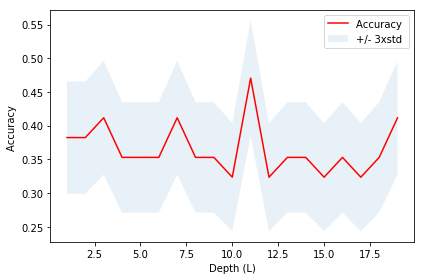

In [202]:
# Plotting the graph on accuracy of the model against the levels of depth.
plt.plot(range(1,L),mean_acc2,'r')
plt.fill_between(range(1,L),mean_acc2 - 1 * std_acc2,mean_acc2 + 1 * std_acc2, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))
plt.ylabel('Accuracy ')
plt.xlabel('Depth (L)')
plt.tight_layout()
plt.show()

In [205]:
print( "The best accuracy was with", mean_acc2.max(), "with depth of", mean_acc2.argmax()+1)

The best accuracy was with 0.47058823529411764 with depth of 11


In [242]:
# Load the ideal decision tree
dTreeFinal = DecisionTreeClassifier(criterion="entropy", max_depth = 7).fit(X_train,y_train)

In [243]:
# Compute the prediction on our X_test
yhatf = dTreeFinal.predict(X_test)

### Evaluation

Now, let us evaluate the accuarcy of the score using the optimal Decision Tree we have modelled above.

In [244]:
Eval = np.array([['Algorithm','Accuracy','Jaccard','F1 Score'],
        ['Decision Tree',metrics.accuracy_score(y_test, yhatf),jaccard_similarity_score(y_test, yhatf),f1_score(y_test, yhatf, average='micro')]])
Eval

array([['Algorithm', 'Accuracy', 'Jaccard', 'F1 Score'],
       ['Decision Tree', '0.38235294117647056', '0.38235294117647056',
        '0.3823529411764706']], dtype='<U19')

In [245]:
pd.DataFrame(data=Eval[1:,1:],    # values
             index=Eval[1:,0],    # 1st column as index
             columns=Eval[0,1:])  # 1st row as the column names

,Accuracy,Jaccard,F1 Score
Decision Tree,0.38235294117647056,0.38235294117647056,0.3823529411764706


### Model Visualisation

We have seen from the result above that the modelling may not be accurate despite we chose the best model for the job. This shows that the dataset `df_new` may not be sufficient or inappropriate for the modelling using the decision trees.

Though the model may not be good enough for us to deduce further results, let us take a look on the resultant model we have just created as it may provide the results that may be quite insightful for us.

In [221]:
#Installing necessary libraries
!pip install pydotplus
!pip install graphviz

In [239]:
from sklearn import datasets
from IPython.display import Image  
from sklearn import tree
import pydotplus

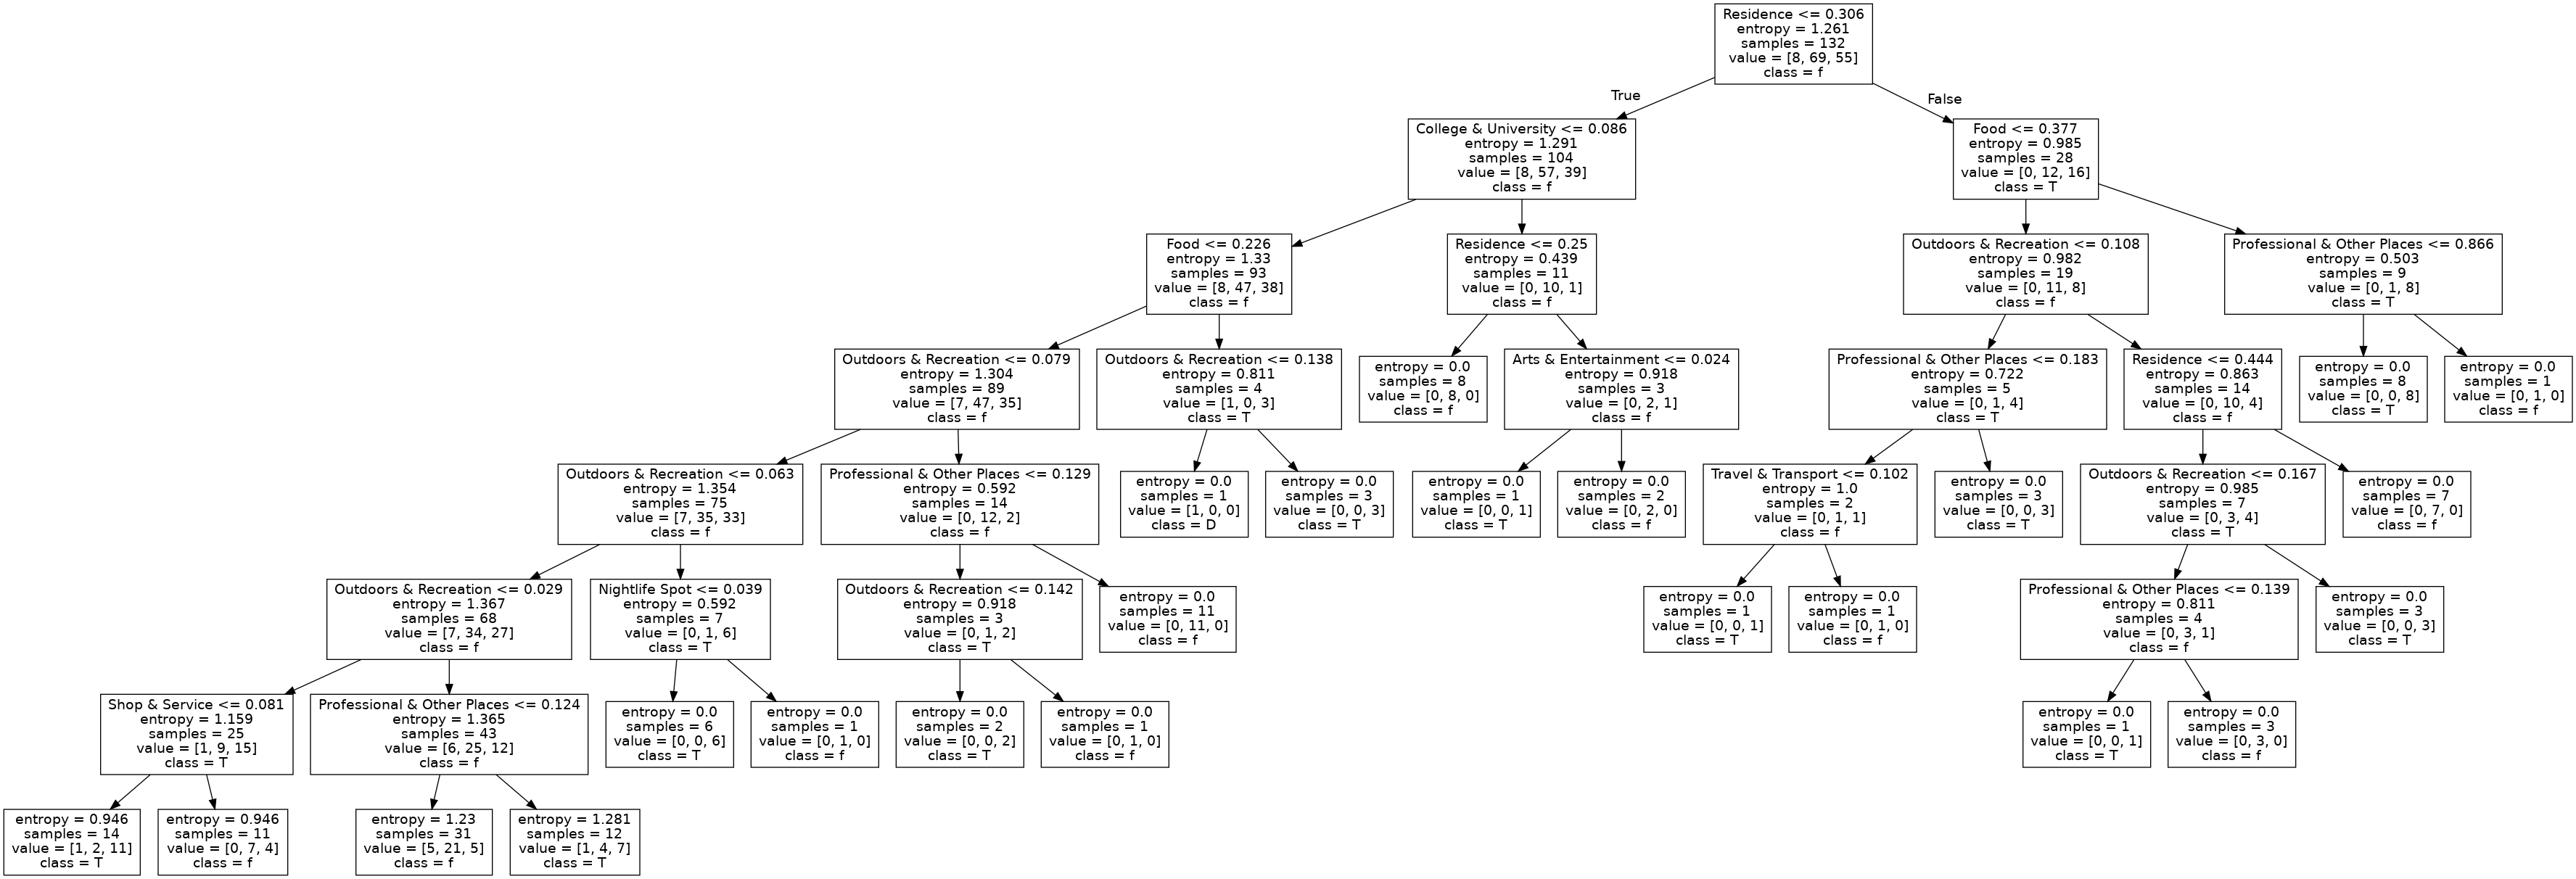

In [246]:
# Create DOT data
dot_data = tree.export_graphviz(dTreeFinal, out_file=None, 
                                feature_names=X.columns,  
                                class_names='DfT Category')

# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## 4. Results <a name = "Results"></a>

Upon inpection of the decision tree we have generated above, key points have been taken on the following:-

1. For stations of DfT Categories A and B only:
    - They are not surrounded with higher density residential area (i.e. Residential Area density which is at most 31%).
    - They have less Outdoors and Recreational Areas surrounding it, with the density of at most 13.8%.
    - They are less likely to be surrounded by Professional and Other Places. This may indicate that there are higher possibility that the working class use these stations as interchange rather than exiting to work. 
2. For stations of DfT Categories E and F only:
    - They are either surrounded by the higher density of residential areas, or
    - Almost surely not surrounded by Colleges or University as <9% of their neighbourhood are surrounded by Colleges and University (with >95% certainty). 

## 5. Discussions <a name="Discussions"></a>

First and foremost, Foursquare data isn’t all-encompassing. The highest number of venues are in the Food and Shop & Service categories and rather low on the residental Category, even in the high-density residental area of Camden, Edgware and so forth. Besides that, we have noticed that almost half (166 out of the total of 348) of the stations in Greater London do not have corresponding neighbourhood data in Foursquare, especially the residental areas and regions close to the London Green Belt.

Moreover, it is worth pointing out that the DfT Category itself is dependent to the Operator of the stations. If you could remember in the [Exploratory Analysis and Data Cleaning](#Exp), we can see that a station named *Highbury & Islington* carries two distinct DfT categories due to the fact that different operators are running on the same station as each operators have different statistics on frequency of trains and passenger count in their respective services. This is also hold true to stations which are very close to each other but operated by different Private companies. (Best example would be *West Hampstead* and *West Hampstead Thameslink* stations.) This may have adversely impacted the results obtained from the modelling and Evaluation process as they have different DfT Categories (D and E respectively) despite they both share the same neighbourhood. But as the projects aims to study the relationship between the composition of the neighbourhood and the DfT Category of each stations, Operators are not consider in this project.

## 6. Conclusion <a name="Conclusion"> </a>

Despite of the following shortcomings found in the Foursquare and the DfT Categories itself, this project has managed to provide a good insight on the neighbourhoods surrounding the stations which are either 'too busy' (DfT Categories A and B) and 'too quiet' (DfT Categories E and F). Moreover, with additional data combined (i.e. annual passenger count at each stations) or even treating the stations within a 1000m radius as a 'cluster' with combined passenger count, this project could yield a more accurate results.